# Import Library

In [1]:
import os
from google.colab import files

import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import ImageFile

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.applications.vgg16 import VGG16  
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201  
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from sklearn.metrics import confusion_matrix, classification_report


# Connect to Kaggle API

In [2]:
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# Download datasets

In [3]:
! kaggle datasets download -d kaustubhb999/tomatoleaf -p /content/images/ --unzip

100% 179M/179M [00:09<00:00, 22.5MB/s]
100% 179M/179M [00:09<00:00, 20.3MB/s]


# Make Dataframe

In [4]:
def define_paths(dir):
    files_path = []
    classes = []
    folders = os.listdir(dir)
    for folder in folders:
        folder_path = os.path.join(dir, folder)
        file_list = os.listdir(folder_path)
        for file_name in file_list:
            fpath = os.path.join(folder_path, file_name)
            files_path.append(fpath)
            classes.append(folder)
    return files_path, classes

def define_df(files, classes):
    file_series = pd.Series(files, name= 'file_paths')
    class_series = pd.Series(classes, name='class')
    return pd.concat([file_series, class_series], axis= 1)

def make_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

In [5]:
train_dir = '/content/images/tomato/train'
valid_dir = '/content/images/tomato/val'

temp_df = make_df(train_dir)
test_df = make_df(valid_dir)

train_df, valid_df = train_test_split(temp_df, train_size=0.9, shuffle=True, random_state=42, stratify=temp_df['class'])

In [6]:
print(train_df.groupby(['class']).count())
print('Train set minimum class count : ', train_df.groupby(['class']).count().min())
print(valid_df.groupby(['class']).count())
print('Validation set minimum class count:', valid_df.groupby(['class']).count().min())
print(test_df.groupby(['class']).count())
print('Test set minimum class count:', test_df.groupby(['class']).count().min())

                                               file_paths
class                                                    
Tomato___Bacterial_spot                               900
Tomato___Early_blight                                 900
Tomato___Late_blight                                  900
Tomato___Leaf_Mold                                    900
Tomato___Septoria_leaf_spot                           900
Tomato___Spider_mites Two-spotted_spider_mite         900
Tomato___Target_Spot                                  900
Tomato___Tomato_Yellow_Leaf_Curl_Virus                900
Tomato___Tomato_mosaic_virus                          900
Tomato___healthy                                      900
Train set minimum class count :  file_paths    900
dtype: int64
                                               file_paths
class                                                    
Tomato___Bacterial_spot                               100
Tomato___Early_blight                                 100
Tomato__

# Image data generator

In [7]:
img_size = (224, 224)
batch = 40
ts_len = len(test_df)
test_batch = max(sorted([ts_len // n for n in range(1, ts_len + 1) if ts_len%n == 0 and ts_len/n <= 80]))

tr_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip= True)

ts_and_vl_datagen = ImageDataGenerator(rescale=1./255)
print('For train')
train_generator = tr_datagen.flow_from_dataframe(
    train_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=True,
    class_mode='categorical')

print('\nFor validation')
validation_generator = ts_and_vl_datagen.flow_from_dataframe(
    valid_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch, 
    shuffle=False,
    class_mode='categorical')

print('\nFor test')
test_generator = ts_and_vl_datagen.flow_from_dataframe(
    test_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=test_batch, 
    shuffle=False,
    class_mode='categorical')

For train
Found 9000 validated image filenames belonging to 10 classes.

For validation
Found 1000 validated image filenames belonging to 10 classes.

For test
Found 1000 validated image filenames belonging to 10 classes.


We use `test_batch = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))` so that we will go through all the sample in the test dataset exactly once.

# Plot Image Sample

In [8]:
def show_sample_images(generator, num_sample=30):
    class_list = list(generator.class_indices.keys())
    images, labels = next(generator)
    plt.figure(figsize= (25, 15))
    length = len(labels)
    sample = min(length, 30)
    for i in range(sample):
        plt.subplot(5, 6, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_list[index]
        plt.title(class_name, color= 'green', fontsize= 14)
        plt.axis('off')
    plt.show()

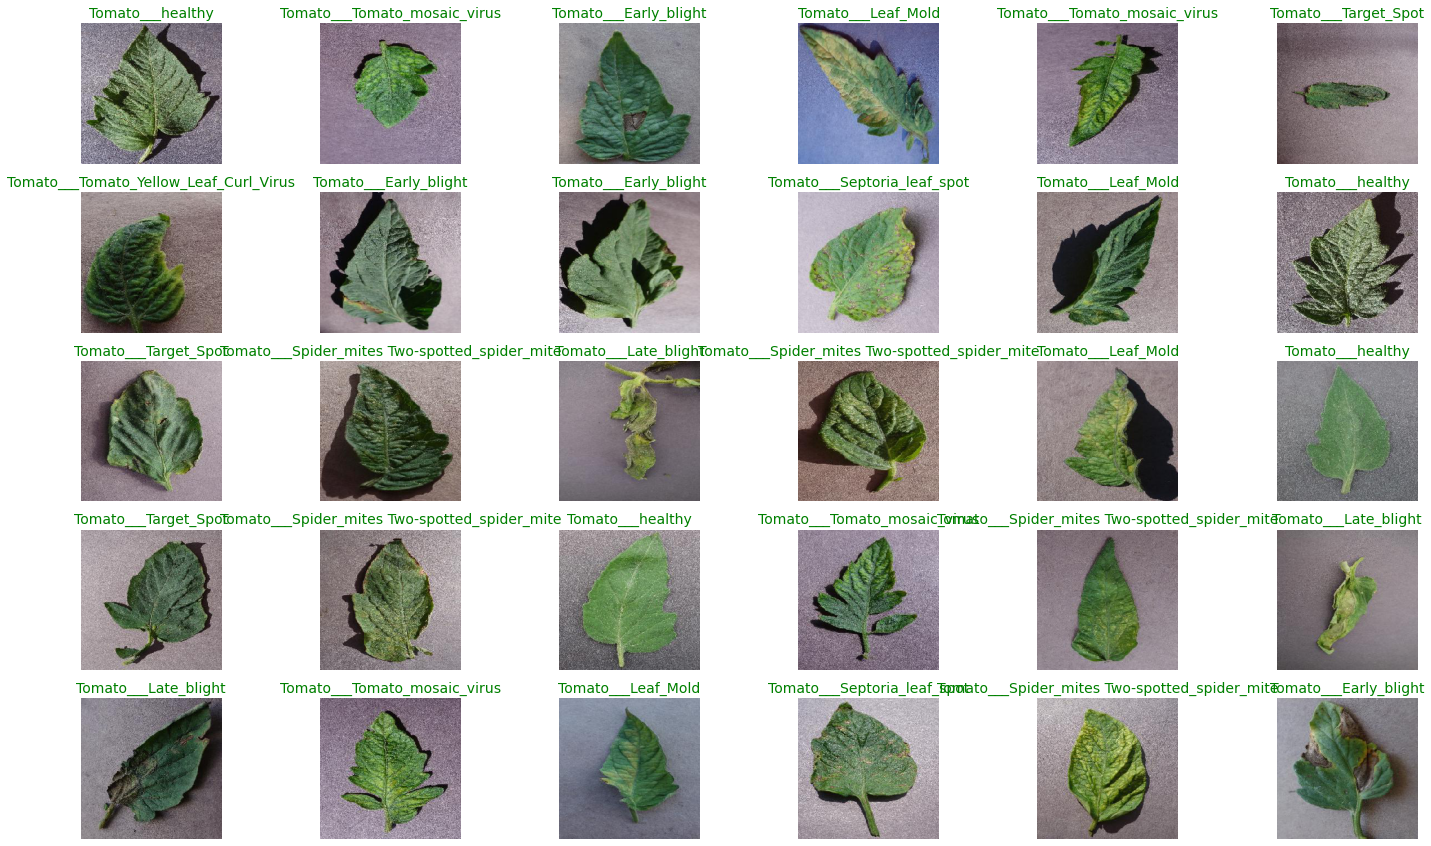

In [9]:
show_sample_images(train_generator)

# Create Model

In [10]:
def create_model(transfer_model):
    img_shape = (224, 224, 3)
    class_num = len(list(train_generator.class_indices.keys()))
    if (transfer_model == "DenseNet201"):
      base_model = DenseNet201(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "Xception"):
      base_model = Xception(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "MobileNetV2"):
      base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape)
    else:
      base_model = VGG16(include_top= False, weights= "imagenet", input_shape= img_shape)
    
    base_model.trainable = False
    
    model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dense(256,
            kernel_regularizer=regularizers.L2(0.015),
            activity_regularizer= regularizers.L1(0.005),
            bias_regularizer= regularizers.L1(0.005),
            activation= 'relu'),
      Dropout(rate= 0.4, seed= 123),
      Dense(class_num, activation= 'softmax')
    ])

    return model


## MobileNetV2 Model

In [12]:
mobilenet = create_model("MobileNetV2")
mobilenet.compile(optimizer="adam", loss= 'categorical_crossentropy', metrics= ['accuracy'])

mobilenet.summary()
mobilenet.layers[0].summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                           

# Custom Callback

In [13]:
class MyCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97):
            print("\nAccuracy has reached 97%!") 
            self.model.stop_training = True
            
my_callbacks = MyCallback()

# Train Model

Run code below so that no truncated images error while train the models

In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

## MobileNetV2 Training

In [16]:
initial_epochs = 30
history_mobilenet = mobilenet.fit(
    x=train_generator, 
    validation_data=validation_generator,
    epochs=initial_epochs, 
    verbose=2, 
    callbacks=[my_callbacks],
    validation_steps= None,
    shuffle= False,
)

Epoch 1/30
225/225 - 45s - loss: 2.9355 - accuracy: 0.7109 - val_loss: 1.3380 - val_accuracy: 0.8220 - 45s/epoch - 200ms/step
Epoch 2/30
225/225 - 25s - loss: 1.2239 - accuracy: 0.8072 - val_loss: 1.0450 - val_accuracy: 0.8080 - 25s/epoch - 111ms/step
Epoch 3/30
225/225 - 25s - loss: 1.0567 - accuracy: 0.8083 - val_loss: 0.9140 - val_accuracy: 0.8610 - 25s/epoch - 110ms/step
Epoch 4/30
225/225 - 27s - loss: 0.9962 - accuracy: 0.8168 - val_loss: 0.8719 - val_accuracy: 0.8540 - 27s/epoch - 121ms/step
Epoch 5/30
225/225 - 25s - loss: 0.9505 - accuracy: 0.8180 - val_loss: 0.8471 - val_accuracy: 0.8410 - 25s/epoch - 110ms/step
Epoch 6/30
225/225 - 24s - loss: 0.9394 - accuracy: 0.8141 - val_loss: 0.8048 - val_accuracy: 0.8540 - 24s/epoch - 109ms/step
Epoch 7/30
225/225 - 25s - loss: 0.9229 - accuracy: 0.8117 - val_loss: 0.8201 - val_accuracy: 0.8510 - 25s/epoch - 109ms/step
Epoch 8/30
225/225 - 24s - loss: 0.9295 - accuracy: 0.8072 - val_loss: 0.8216 - val_accuracy: 0.8360 - 24s/epoch - 109

# Plot Model Training

In [17]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    Epochs = [i+1 for i in range(len(acc))]
    
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, acc, label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, loss, label= 'Training loss')
    plt.plot(Epochs, val_loss, label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label) 
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

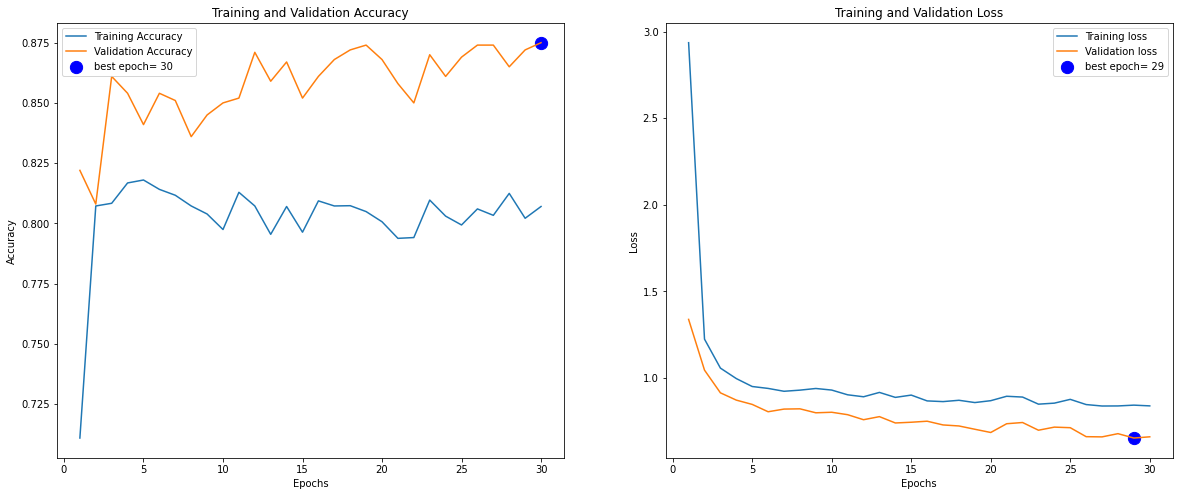

In [18]:
plot_training(history_mobilenet)

# Fine Tuning

## MobileNetV2

In [22]:
mobilenet.layers[0].trainable = True
mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2,588,490
Trainable params: 2,554,378
Non-

In [23]:
mobilenet.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [24]:
fine_tune_epoch = 20

total_epochs =  initial_epochs + fine_tune_epoch

history_mobilenet_fine = mobilenet.fit(x=train_generator,
                         epochs=total_epochs,
                         initial_epoch=history_mobilenet.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=[my_callbacks])

Epoch 30/50
  6/225 [..............................] - ETA: 55s - loss: 2.6158 - accuracy: 0.3292

225/225 [==============================] - 68s 276ms/step - loss: 1.4305 - accuracy: 0.6019 - val_loss: 1.1152 - val_accuracy: 0.7200
Epoch 31/50
225/225 [==============================] - 61s 270ms/step - loss: 0.8822 - accuracy: 0.7911 - val_loss: 1.3059 - val_accuracy: 0.6930
Epoch 32/50
225/225 [==============================] - 61s 269ms/step - loss: 0.7321 - accuracy: 0.8463 - val_loss: 1.2293 - val_accuracy: 0.7080
Epoch 33/50
225/225 [==============================] - 61s 270ms/step - loss: 0.6594 - accuracy: 0.8704 - val_loss: 1.1547 - val_accuracy: 0.7260
Epoch 34/50
225/225 [==============================] - 61s 270ms/step - loss: 0.6078 - accuracy: 0.8876 - val_loss: 0.9974 - val_accuracy: 0.7590
Epoch 35/50
225/225 [==============================] - 61s 270ms/step - loss: 0.5526 - accuracy: 0.9040 - val_loss: 0.8767 - val_accuracy: 0.7930
Epoch 36/50
225/225 [==============================] - 61s 271ms/step - loss: 0.5091 - accuracy: 0.9208 - val_loss: 0.7753 - val_accurac

# Plot model before and after fine tuning

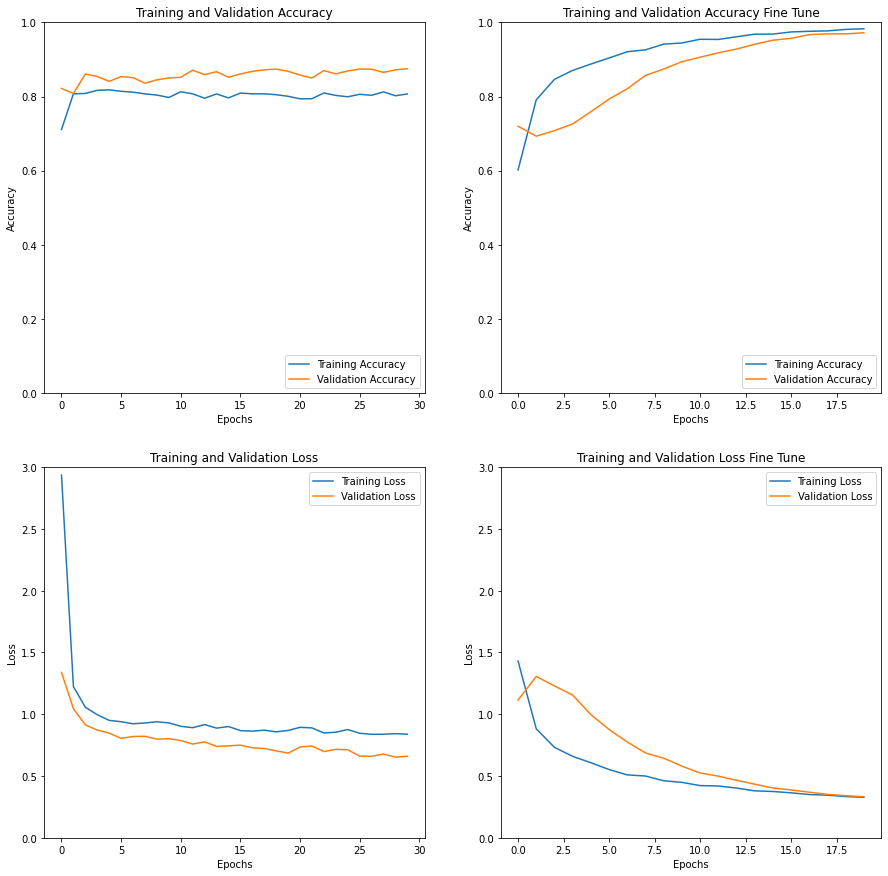

In [26]:
plt.figure(figsize= (15, 15))

plt.subplot(2, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label= 'Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history_mobilenet_fine.history['accuracy'], label= 'Training Accuracy')
plt.plot(history_mobilenet_fine.history['val_accuracy'], label= 'Validation Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy Fine Tune')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history_mobilenet.history['loss'], label= 'Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label= 'Validation Loss')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')


plt.subplot(2, 2, 4)
plt.plot(history_mobilenet_fine.history['loss'], label= 'Training Loss')
plt.plot(history_mobilenet_fine.history['val_loss'], label= 'Validation Loss')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss Fine Tune')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout
plt.show()

# Evaluate model

In [27]:
ts_length = len(test_df)
steps = ts_length // test_batch
train_score = mobilenet.evaluate(train_generator, steps=steps, verbose= 1)
valid_score = mobilenet.evaluate(validation_generator, steps=steps, verbose= 1)
test_score = mobilenet.evaluate(test_generator, steps=steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 3s 122ms/step - loss: 0.3681 - accuracy: 0.9550
Train Loss:  0.2581610679626465
Train Accuracy:  1.0
--------------------
Validation Loss:  0.33525657653808594
Validation Accuracy:  0.9712499976158142
--------------------
Test Loss:  0.36811426281929016
Test Accuracy:  0.9549999833106995


# Prediction

In [28]:
preds = mobilenet.predict(test_generator)
y_pred = [np.argmax(y) for y in preds]
print(y_pred)

20/20 [==============================] - 3s 121ms/step
[3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6,

# Evaluation

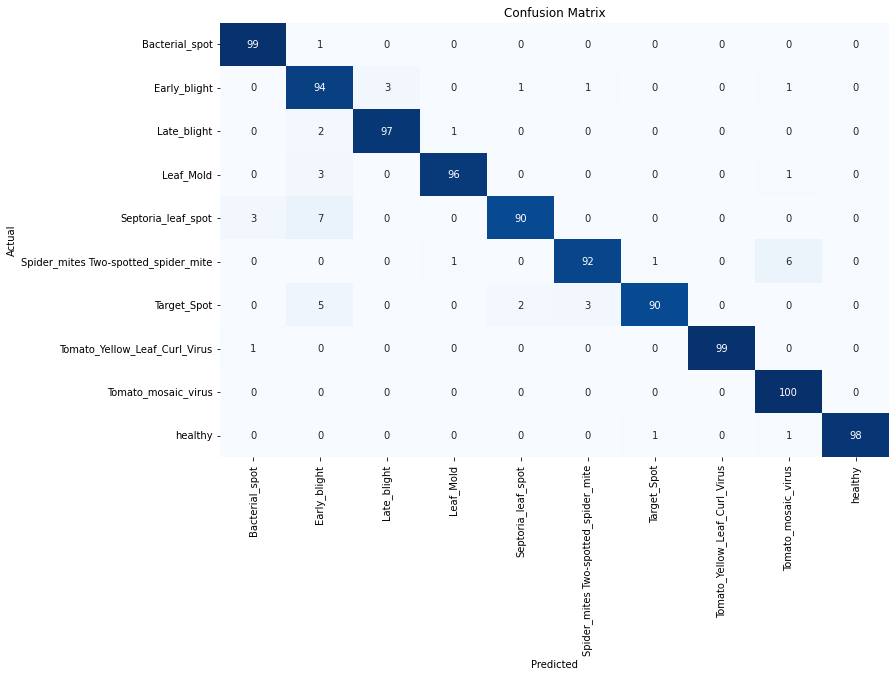


Classification Report:
----------------------
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.96      0.99      0.98       100
                        Early_blight       0.84      0.94      0.89       100
                         Late_blight       0.97      0.97      0.97       100
                           Leaf_Mold       0.98      0.96      0.97       100
                  Septoria_leaf_spot       0.97      0.90      0.93       100
Spider_mites Two-spotted_spider_mite       0.96      0.92      0.94       100
                         Target_Spot       0.98      0.90      0.94       100
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.99      0.99       100
                 Tomato_mosaic_virus       0.92      1.00      0.96       100
                             healthy       1.00      0.98      0.99       100

                            accuracy                           0.95      1000
               

In [29]:
def make_evaluation(test_gen, y_pred):
  classes = [label[9:] for label in list(test_gen.class_indices.keys())] # slice word "Tomato___"
  class_count = len(classes)
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(12, 8))
  sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)     
  plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
  plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  print("\nClassification Report:\n----------------------")
  print(classification_report(test_generator.classes, y_pred, target_names=classes))

make_evaluation(test_generator, y_pred)

# Save Model

# saved_model

In [30]:
save_path = 'saved_model/'
tf.saved_model.save(mobilenet, save_path)

In [31]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/variables/variables.index (deflated 79%)
  adding: content/saved_model/saved_model.pb (deflated 91%)


## HDF5 Model

In [33]:
mobilenet.save("model.h5")

## ONNX Model

In [34]:
!pip install onnxruntime
!pip install -U tf2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 30.8 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 86 kB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 31.5 MB/s 
     |████████████████████████████████| 13.1 MB 59.6 MB/s 


In [35]:
!python -m tf2onnx.convert --saved-model "saved_model" --output "model.onnx" --extra_opset ai.onnx.contrib:1

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-12-02 13:41:53,573 - WARNING - tensorflow_text not installed. Model will fail to load if tensorflow_text ops are used.
2022-12-02 13:41:54,382 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-12-02 13:42:00,425 - INFO - Signatures found in model: [serving_default].
2022-12-02 13:42:00,425 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-12-02 13:42:00,426 - INFO - Output names: ['dense_1']
2022-12-02 13:42:01,662 - INFO - Using tensorflow=2.9.2, onnx=1.12.0, tf2onnx=1.13.0/2c1db5
2022-12-02 13:42:01,663 - INFO - Using opset <onnx, 13>
2022-12-02 13:42:02,349 - INFO - Computed 0 values for constant folding
2022-12-02 13:42:02,989 - INFO - Optimizing ONNX model
2022-12-02 13:42:05,582

## Pickle Model

In [36]:
import pickle

pickle.dump(mobilenet, open('model.pkl', 'wb'))